In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import rdkit, rdkit.Chem.Crippen
import tqdm.auto as tqdm

In [2]:
import cigin
import molspace

In [3]:
model = cigin.predictor.CIGINPredictor("../weights/best_model.pth")

In [4]:
df = pd.read_csv("../../data/solvatum/train.csv", sep=';')
df

,Solute,Solvent,SoluteSMILES,SolventSMILES,DeltaGsolv
0,HYDROGEN SULFIDE,4-FORMYLMORPHOLINE,S,C1COCCN1C=O,-1.81
1,HYDROGEN SULFIDE,ACETIC ACID,S,CC(=O)O,-1.50
2,HYDROGEN SULFIDE,ACETONE,S,CC(=O)C,-1.90
3,HYDROGEN SULFIDE,BROMOBENZENE,S,c1ccc(cc1)Br,-1.30
4,HYDROGEN SULFIDE,CHLOROBENZENE,S,c1ccc(cc1)Cl,-1.50
...,...,...,...,...,...
5494,TRANS-PIPERYLENE,N-ETHYLACETAMIDE,C/C=C/C=C,CCNC(=O)C,-3.03
5495,TRANS-PIPERYLENE,N-METHYLACETAMIDE,C/C=C/C=C,C/C(=N/C)/O,-2.99
5496,TRANS-PIPERYLENE,N-METHYLFORMAMIDE,C/C=C/C=C,C/N=C/O,-2.59
5497,TRANS-PIPERYLENE,N-METHYLPYRROLIDONE,C/C=C/C=C,CN1CCCC1=O,-3.04


In [5]:
similarities, differences = [], []

with tqdm.tqdm(total=len(df), desc="Plotting Lipschitz Bounds") as progress_bar:
    for solvent in df['SolventSMILES'].unique():
        df_relevant = df[df['SolventSMILES'] == solvent]
        for i in range(len(df_relevant)):
            for j in range(i):
                s1, dg1, s2, dg2 = (
                    df_relevant["SoluteSMILES"].iloc[i],
                    df_relevant["DeltaGsolv"].iloc[i],
                    df_relevant["SoluteSMILES"].iloc[j],
                    df_relevant["DeltaGsolv"].iloc[j]
                )
                m1 = rdkit.Chem.MolFromSmiles(s1)
                m2 = rdkit.Chem.MolFromSmiles(s2)
                sim = molspace.dataspace.similarity.molecule_similarity(m1, m2)
                diff = abs(molspace.predictors.drug_likeness.predict_log_p(m1) - molspace.predictors.drug_likeness.predict_log_p(m2))
                similarities.append(sim)
                differences.append(diff)
            progress_bar.update(1)

Plotting Lipschitz Bounds:   0%|          | 0/5499 [00:00<?, ?it/s]

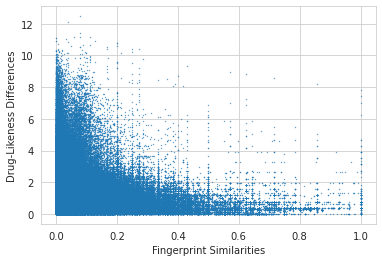

In [6]:
plt.scatter(similarities, differences, s=0.1)
plt.xlabel('Fingerprint Similarities')
plt.ylabel('Drug-Likeness Differences')
plt.show()

<AxesSubplot:xlabel='Fingerprint Similarity', ylabel='Drug-Likeness Difference'>

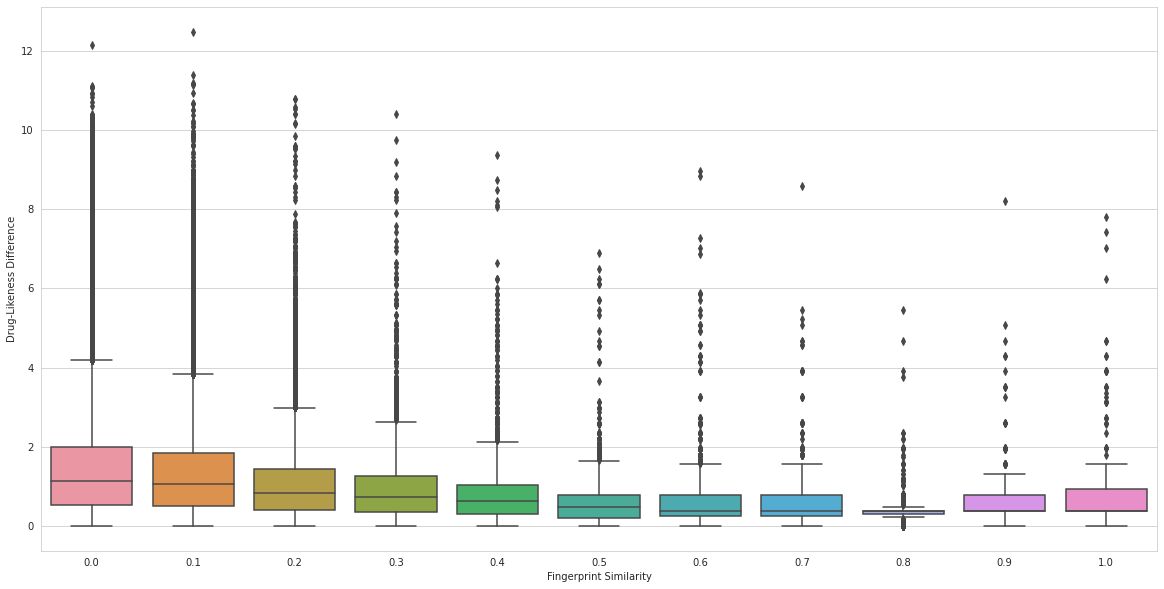

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_xlabel("Fingerprint Similarity")
ax.set_ylabel("Drug-Likeness Difference")
sns.boxplot(x=np.round(similarities, decimals=1), y=differences, ax=ax)